# Imports

In [57]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation import steiner_tree

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from bokeh.plotting import figure, show, output_notebook, from_networkx, output_file, save
from bokeh.models import Circle, HoverTool, MultiLine, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4


import warnings
warnings.filterwarnings('ignore')

# Create graph

In [58]:
edges           = pd.read_csv('../data/edges_191120.csv')
nodes           = pd.read_csv('../data/nodes_191120.csv', index_col=0)
ingr2cat        = pd.read_csv('../data/dict_ingr2cate.csv')
all_categories = set(ingr2cat['category'].values)

embeddings_dict = pickle.load(open('../data/FlavorGraph_Node_Embedding.pickle', 'rb'))

id_to_name = dict(zip(nodes.index, nodes['name']))

ingredients_idx = nodes[nodes['node_type']=='ingredient'].index.tolist()
nodes           = nodes.loc[ingredients_idx]#.reset_index(drop=True)
embeddings_dict = {k: embeddings_dict[k] for k in map(str, ingredients_idx)}

In [59]:
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'], weight=row['score'], type=row['edge_type'])
for node_id, row in nodes.iterrows():
    G.add_node(node_id, name=row['name'], node_type=row['node_type'], is_hub=row['is_hub'])

In [60]:
# remove nodes from graph that are not ingredients
to_remove = [n for n in G.nodes if n not in nodes.index]
G.remove_nodes_from(to_remove)

# remove nodes that are not hubs
# to_remove = [n for n, attr in G.nodes(data=True) if attr['is_hub'] != 'hub']
# G.remove_nodes_from(to_remove)

In [61]:
# Remove NaN edges
to_remove = [(u, v) for u, v, attr in G.edges(data=True) if pd.isna(attr['weight'])]
G.remove_edges_from(to_remove)

# Remove isolated nodes (nodes with degree 0)
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
print(f"Removed {len(isolated)} isolated nodes")

Removed 0 isolated nodes


# Get ID from NAME

In [62]:
subset = nodes[nodes['name'].str.contains('beer', case=False, na=False)]
# subset = subset[subset['is_hub'] == 'hub']
subset

,name,id,node_type,is_hub
node_id,,,,
122,amber_beer,NaN,ingredient,no_hub
423,beer,NaN,ingredient,hub
562,bock_beer,NaN,ingredient,no_hub
761,budweiser_beer,NaN,ingredient,no_hub
1627,corona_beer,NaN,ingredient,no_hub
1805,dark_beer,NaN,ingredient,no_hub
1823,dark_mexican_beer,NaN,ingredient,no_hub
2839,ginger_beer,NaN,ingredient,no_hub
3635,lager_beer,NaN,ingredient,no_hub


In [63]:
terminals = [4635,6441,1138,3560,423]
food_names = [id_to_name[t] for t in terminals]
food_names

['pasta', 'tomato', 'chicken', 'kefir', 'beer']

# Embedding methods

In [64]:
food_embeddings = np.array([embeddings_dict[str(t)] for t in terminals])
combi_embedding = np.mean(food_embeddings, axis=0)

In [65]:
# compute cosine similarity between combined embedding and all ingredient embeddings
all_embeddings = np.array([embeddings_dict[str(n)] for n in G.nodes()])
similarities = cosine_similarity([combi_embedding], all_embeddings).flatten()

# get top N most similar ingredients (not in terminals)
N = 7
similarity_series = pd.Series(similarities, index=G.nodes())
similarity_series = similarity_series.drop(index=terminals)
top_n = similarity_series.nlargest(N)
top_n_ingredients = [(idx, id_to_name[idx], score) for idx, score in top_n.items()]

def print_markdown_table(ingredients):
    print("| Ingredient ID | Ingredient Name | Similarity Score |")
    print("|---------------|-----------------|------------------|")
    for idx, name, score in ingredients:
        print(f"| {idx} | {name} | {score:.4f} |")

print_markdown_table(top_n_ingredients)

| Ingredient ID | Ingredient Name | Similarity Score |
|---------------|-----------------|------------------|
| 4785 | pickle_spear | 0.6443 |
| 3790 | light_balsamic_vinaigrette_salad_dressing | 0.6356 |
| 5985 | soy_cheddar_cheese | 0.6339 |
| 66 | ahi | 0.6308 |
| 3009 | green_jalapeno_pepper | 0.6274 |
| 2997 | green_chutney | 0.6273 |
| 2103 | dry_chili_pepper | 0.6248 |


In [66]:
# # Apply T-SNE to visualize all embeddings
# # tsne = TSNE(n_components=2, perplexity=100, random_state=42)
# # all_embeddings_2d = tsne.fit_transform(all_embeddings)
# # embedding_df = pd.DataFrame(all_embeddings_2d, index=G.nodes(), columns=['TSNE1', 'TSNE2'])

# # define point categories from ingr2cat
# ingr2cat_dict = dict(zip(ingr2cat['ingredient'], ingr2cat['category']))
# embedding_df['category'] = embedding_df.index.map(lambda x: ingr2cat_dict.get(id_to_name[x], np.nan))
# embedding_df['food_name'] = embedding_df.index.map(lambda x: ' '.join(str(id_to_name[x]).split('_')).title())
# cat_colors = {
#     'Cereal/Crop/Bean': '#D4A574',        # Warm tan/wheat
#     'Sauce/Powder/Dressing': '#E63946',   # Rich red
#     'Dairy': '#F4F1E8',                   # Cream/off-white
#     'Seafood': '#4A90E2',                 # Ocean blue
#     'Essential Oil/Fat': '#F4D03F',       # Golden yellow
#     'Dish/End Product': '#8B4513',        # Saddle brown
#     'Meat/Animal Product': '#C54B4B',     # Deep rose/meat red
#     'Bakery/Dessert/Snack': '#FFB6C1',    # Light pink/pastry
#     'Plant/Vegetable': '#4CAF50',         # Fresh green
#     'Flower': '#DA70D6',                  # Orchid purple
#     'Nut/Seed': '#8B6F47',                # Nutty brown
#     'ETC': '#9E9E9E',                     # Neutral gray
#     'Beverage Alcoholic': '#722F37',      # Wine/burgundy
#     'Spice': '#D2691E',                   # Cinnamon/rust
#     'Fruit': '#FF6B6B',                   # Coral red/fruit
#     'Fungus': '#A0826D',                  # Mushroom beige
#     'Beverage': '#87CEEB',                # Sky blue
# }
# embedding_df['color'] = embedding_df['category'].map(cat_colors).fillna('black')

# is_hub = nodes.loc[embedding_df.index, 'is_hub']
# hub_embeddings   = embedding_df[is_hub == 'hub']
# nohub_embeddings = embedding_df[is_hub != 'hub']



In [67]:
# # Bokeh interactive T-SNE visualization
# from bokeh.models import ColumnDataSource

# # Prepare data for Bokeh
# plot_data = embedding_df.copy()
# plot_data['is_hub'] = nodes.loc[embedding_df.index, 'is_hub']

# # Separate hub and non-hub data
# hub_data = plot_data[plot_data['is_hub'] == 'hub']
# nohub_data = plot_data[plot_data['is_hub'] != 'hub']

# # Create Bokeh figure with fresh hover tool
# p = figure(width=1000, height=600, 
#            title="T-SNE Visualization of Ingredient Embeddings (Interactive)",
#            tools="pan,wheel_zoom,box_zoom,reset,save")

# # Create data source for non-hub
# nohub_source = ColumnDataSource(nohub_data)

# # Plot non-hub nodes (smaller, grey)
# nohub_scatter = p.circle('TSNE1', 'TSNE2', source=nohub_source,
#                          size=6, color='grey', alpha=0.5, marker='diamond',
#                          legend_label='Non-hub ingredients')

# # Plot hub nodes by category to get separate legend entries
# for category in hub_data['category'].unique():
#     category_data = hub_data[hub_data['category'] == category]
#     hub_source = ColumnDataSource(category_data)
    
#     p.scatter('TSNE1', 'TSNE2', source=hub_source,
#               size=12, marker='hex', line_width=2,
#               color='black', fill_color='color',
#               legend_label=category)

# # After creating all your scatter plots, add padding to x-range
# x_margin = (hub_data['TSNE1'].max() - hub_data['TSNE1'].min()) * 0.4
# p.x_range.end = hub_data['TSNE1'].max() + x_margin

# # Add fresh hover tool
# hover_tsne = HoverTool(
#     tooltips=[
#         ("Ingredient", "@food_name"),
#         ("Category", "@category")
#     ]
# )
# p.add_tools(hover_tsne)

# # Customize plot
# p.xaxis.axis_label = "TSNE1"
# p.yaxis.axis_label = "TSNE2"
# p.legend.click_policy = "hide"
# p.legend.location = "top_right"



# # show(p)
# output_file("../data/tsne.html")
# save(p)

# Graph algorithms

### Shortest path between 2 nodes

In [68]:
# find shortest path between two ingredients
def find_shortest_path(ingr_id_1, ingr_id_2):
    try:
        path = nx.shortest_path(G, source=ingr_id_1, target=ingr_id_2, method='dijkstra')
        return path
    except nx.NetworkXNoPath:
        return None
    
ingr_id_1 = terminals[0]  
ingr_id_2 = terminals[1]
print(f"Finding shortest path between {id_to_name[ingr_id_1].upper()} and {id_to_name[ingr_id_2].upper()}:")
path = find_shortest_path(ingr_id_1, ingr_id_2)
if path:
    path_names = [id_to_name[node_id] for node_id in path]
    print(" -> ".join(path_names))
else:
    print(f"No path found between {id_to_name[ingr_id_1]} and {id_to_name[ingr_id_2]}")

Finding shortest path between PASTA and TOMATO:
pasta -> canned_tuna -> tomato


### Smallest subgraph with K specific nodes

In [69]:
# Steiner Tree Problem: find smallest subgraph that includes K nodes
steiner_tree_result = steiner_tree(G, terminals, weight='weight')

# Get all nodes from the Steiner tree, then extract the INDUCED subgraph from G
# This includes ALL original edges between those nodes, not just tree edges
steiner_nodes = list(steiner_tree_result.nodes())
steiner_subgraph = G.subgraph(steiner_nodes).copy()

print("Steiner Tree Nodes:")
for node_id in steiner_subgraph.nodes:
    print(f"{node_id}: {id_to_name[node_id]}")

print(f"\nSteiner tree edges: {steiner_tree_result.number_of_edges()}")
print(f"Induced subgraph edges: {steiner_subgraph.number_of_edges()}")
if steiner_subgraph.number_of_edges() > steiner_tree_result.number_of_edges():
    print(f"  → Restored {steiner_subgraph.number_of_edges() - steiner_tree_result.number_of_edges()} additional edges from G")

Steiner Tree Nodes:
903: canned_chicken
4116: mayonnaise
4635: pasta
3743: lemon_juice
928: canned_peach
294: baking_soda
6311: table_cream
423: beer
6441: tomato
3631: kumara
6711: vegetable_oil
4419: nonfat_cottage_cheese
6218: sun_dried_tomato_pesto
339: batter
4830: pillsbury_refrigerated_crescent_dinner_roll
483: black_currant
5608: salt
2793: garlic
3560: kefir
4204: milk
1138: chicken
6644: vanilla_extract
5371: reduced_fat_margarine

Steiner tree edges: 22
Induced subgraph edges: 39
  → Restored 17 additional edges from G


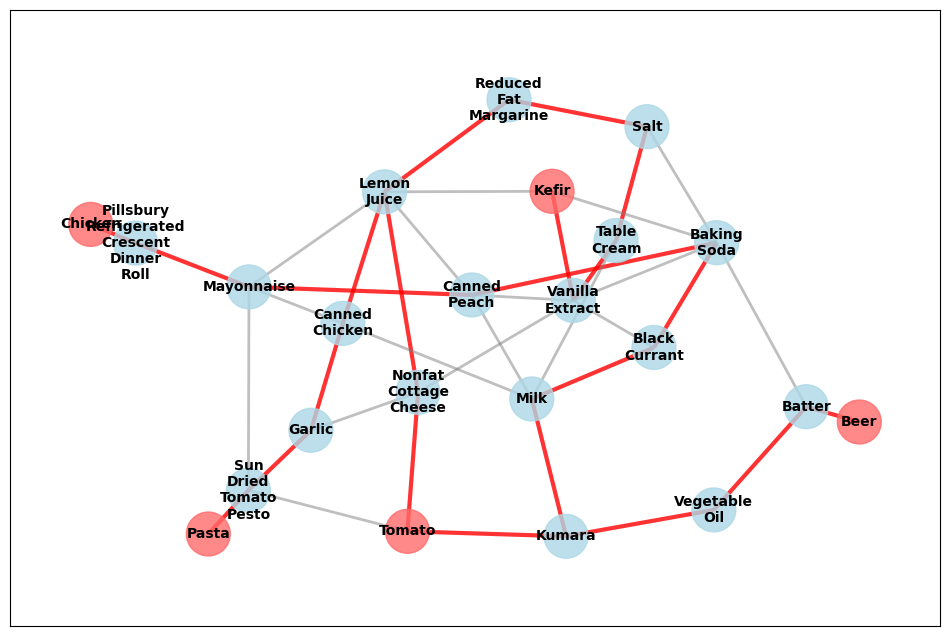

In [70]:

# Visualize the Steiner Tree with original optimal edges in red
plt.figure(figsize=(12, 8))
pos = nx.forceatlas2_layout(steiner_subgraph, distributed_action=True, weight=None, seed=2)

# Color terminal nodes differently
node_colors = ['#FF6B6B' if n in terminals else 'lightblue' for n in steiner_subgraph.nodes()]

# Separate edges: original Steiner tree edges (red) vs additional edges (gray)
steiner_edges = set(steiner_tree_result.edges())
optimal_edges = [(u, v) for u, v in steiner_subgraph.edges() if (u, v) in steiner_edges or (v, u) in steiner_edges]
additional_edges = [(u, v) for u, v in steiner_subgraph.edges() if (u, v) not in steiner_edges and (v, u) not in steiner_edges]

# Draw nodes
nx.draw_networkx_nodes(steiner_subgraph, pos, node_size=1000, node_color=node_colors, alpha=0.8)

# Draw optimal edges in red (thicker)
nx.draw_networkx_edges(steiner_subgraph, pos, edgelist=optimal_edges, edge_color='#FF0000', width=3, alpha=0.8)

# Draw additional edges in gray (thinner)
nx.draw_networkx_edges(steiner_subgraph, pos, edgelist=additional_edges, edge_color='gray', width=2, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(steiner_subgraph, pos, labels={n: '\n'.join(id_to_name[n].split('_')).title() for n in steiner_nodes}, font_size=10, font_weight='bold')

plt.axis('equal')
plt.show()

In [80]:
def connecting_backbone(G, terminals):
    """Find minimal subgraph connecting all terminals, preferring shared nodes"""
    
    # Find ALL shortest paths between terminal pairs
    all_shortest_paths = {}
    for i, t1 in enumerate(terminals):
        for t2 in terminals[i+1:]:
            # Get all shortest paths
            paths = list(nx.all_shortest_paths(G, t1, t2))
            all_shortest_paths[(t1, t2)] = paths
    
    # Score each path by how many times its intermediate nodes appear in other paths
    def score_path(path, all_paths):
        intermediates = set(path[1:-1])
        score = 0
        for other_paths in all_paths.values():
            for other_path in other_paths:
                other_intermediates = set(other_path[1:-1])
                score += len(intermediates & other_intermediates)
        return score
    
    # Choose best path for each terminal pair
    best_paths = {}
    for (t1, t2), paths in all_shortest_paths.items():
        best_path = max(paths, key=lambda p: score_path(p, all_shortest_paths))
        best_paths[(t1, t2)] = best_path
    
    # Build MST using these paths
    terminal_graph = nx.Graph()
    for (t1, t2), path in best_paths.items():
        terminal_graph.add_edge(t1, t2, weight=len(path) - 1, path=path)
    
    mst = nx.minimum_spanning_tree(terminal_graph)
    
    # Collect edges from MST paths
    edges = set()
    for t1, t2, data in mst.edges(data=True):
        path = data['path']
        for j in range(len(path) - 1):
            edges.add((path[j], path[j+1]))
    
    nodes = set(node for edge in edges for node in edge)
    return G.subgraph(nodes).copy()

result = connecting_backbone(G, terminals)

In [81]:
# show adjacency matrix
adj_matrix = nx.adjacency_matrix(result).todense()
adj_df = pd.DataFrame(adj_matrix, index=[id_to_name[n] for n in result.nodes], columns=[id_to_name[n] for n in result.nodes])

mat = (adj_df>0).astype(int)
mat

,beer,cucumber,tomato,stock_cube,kefir,chicken,bermuda_onion,pasta
beer,0,0,0,0,0,0,1,0
cucumber,0,0,1,0,1,0,1,0
tomato,0,1,0,1,0,0,1,0
stock_cube,0,0,1,0,0,1,0,1
kefir,0,1,0,0,0,0,0,0
chicken,0,0,0,1,0,0,0,0
bermuda_onion,1,1,1,0,0,0,0,0
pasta,0,0,0,1,0,0,0,0


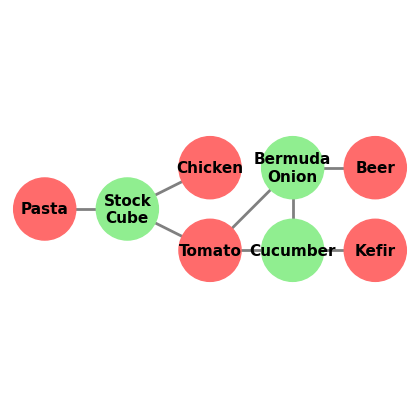

Backbone nodes: ['beer', 'cucumber', 'tomato', 'stock_cube', 'kefir', 'chicken', 'bermuda_onion', 'pasta']
Terminals (red): ['pasta', 'tomato', 'chicken', 'kefir', 'beer']


In [82]:
# visualize the resulting subgraph
plt.figure(figsize=(4,4))
pos = nx.bfs_layout(result, start=terminals[0])

# Color terminal nodes differently
node_colors = ['#FF6B6B' if n in terminals else 'lightgreen' for n in result.nodes()]

nx.draw(result, pos, with_labels=True, labels={n: '\n'.join(id_to_name[n].split('_')).title() for n in result.nodes()}, 
        node_size=2000, node_color=node_colors, font_size=11, font_weight='bold', edge_color='gray', width=2)
plt.axis('equal')
plt.show()

# Verify structure
print("Backbone nodes:", [id_to_name[n] for n in result.nodes()])
print("Terminals (red):", [id_to_name[t] for t in terminals])